## Advanced Lane Finding Project

### 02 Thresholded Binary Image

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard image.
* **Apply a distortion correction to raw images.**
* **Use color transforms, gradients, etc., to create a thresholded binary image.**
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Load and show test images

In [2]:
# Load test images.
test_images = list(map(lambda filename: (filename, cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)), glob.glob('test_images/*.jpg')))

In [3]:
# Display images on a [cols, rows] subplot grid
def show_images(images, cols = 4, rows = 2, figsize=(25,6), cmap = None):
    f, axes = plt.subplots(rows, cols, figsize=figsize)
    f.tight_layout()
    plt.subplots_adjust(left=0., right=1, top=1.4, bottom=0.)
    
    indexes = range(cols * rows)
    
    for ax, index in zip(axes.flat, indexes):
        if index < len(images):
            filename, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(filename, fontsize=25)

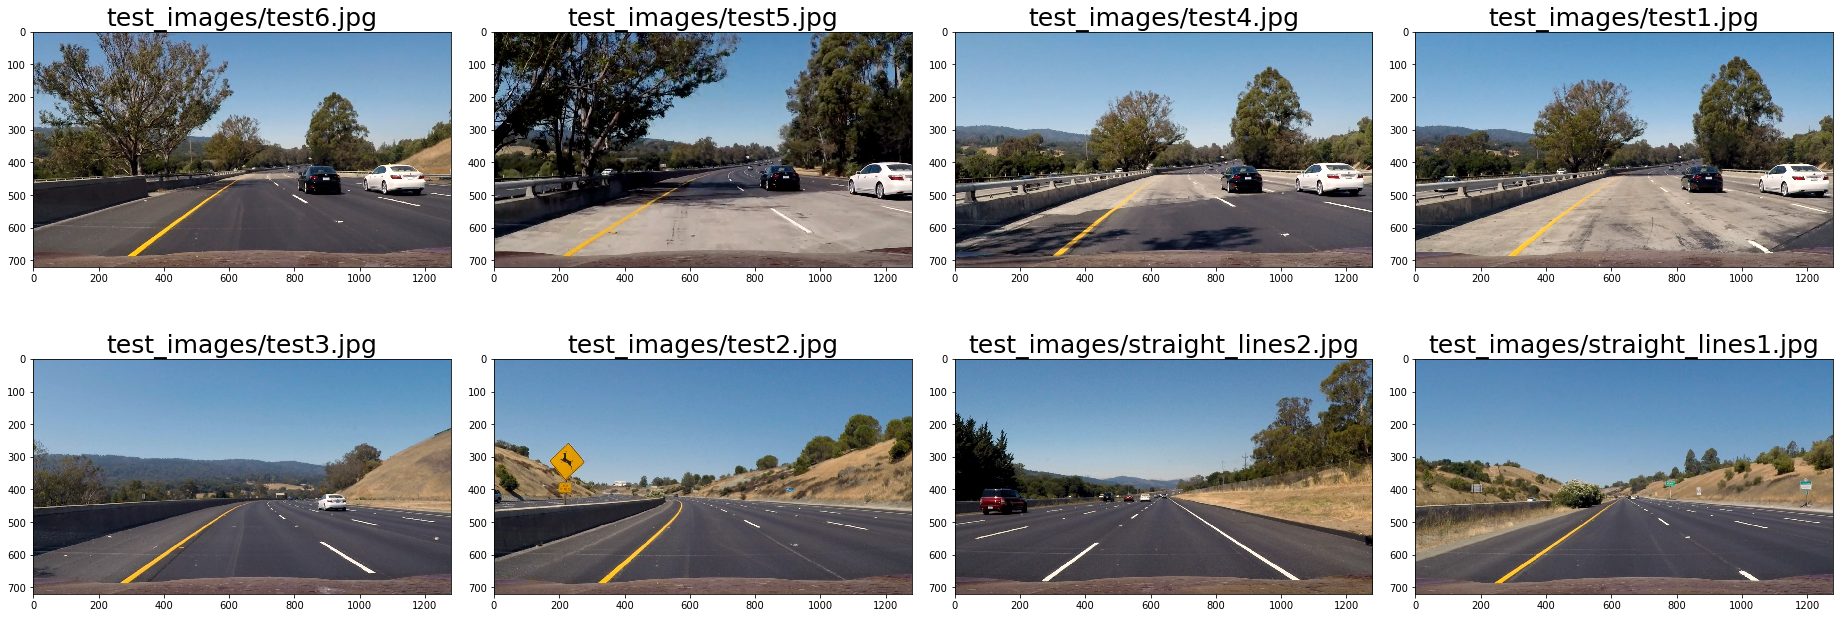

In [4]:
# Show test images
show_images(test_images, 4, 2, (25,6))

## Apply a distortion correction to raw images

In [5]:
# Loading camera calibration (calculated in 01_Camera_Calibartion.ipynb)
camera_cal = pickle.load(open('camera_cal/camera_calibration.p', 'rb'))
mtx, dist = map(camera_cal.get, ('mtx', 'dist'))

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

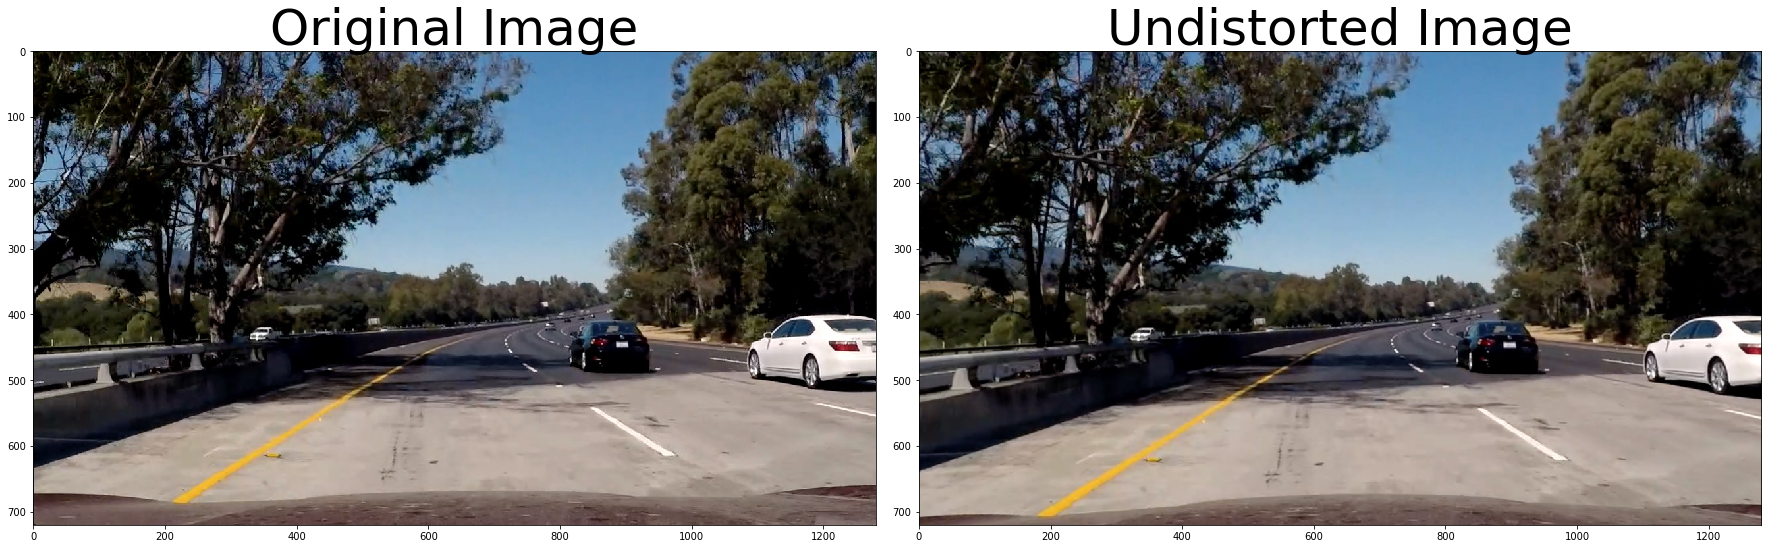

In [6]:
index = 1
test_image = test_images[index][1]
undistort_image = undistort(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) 
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistort_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

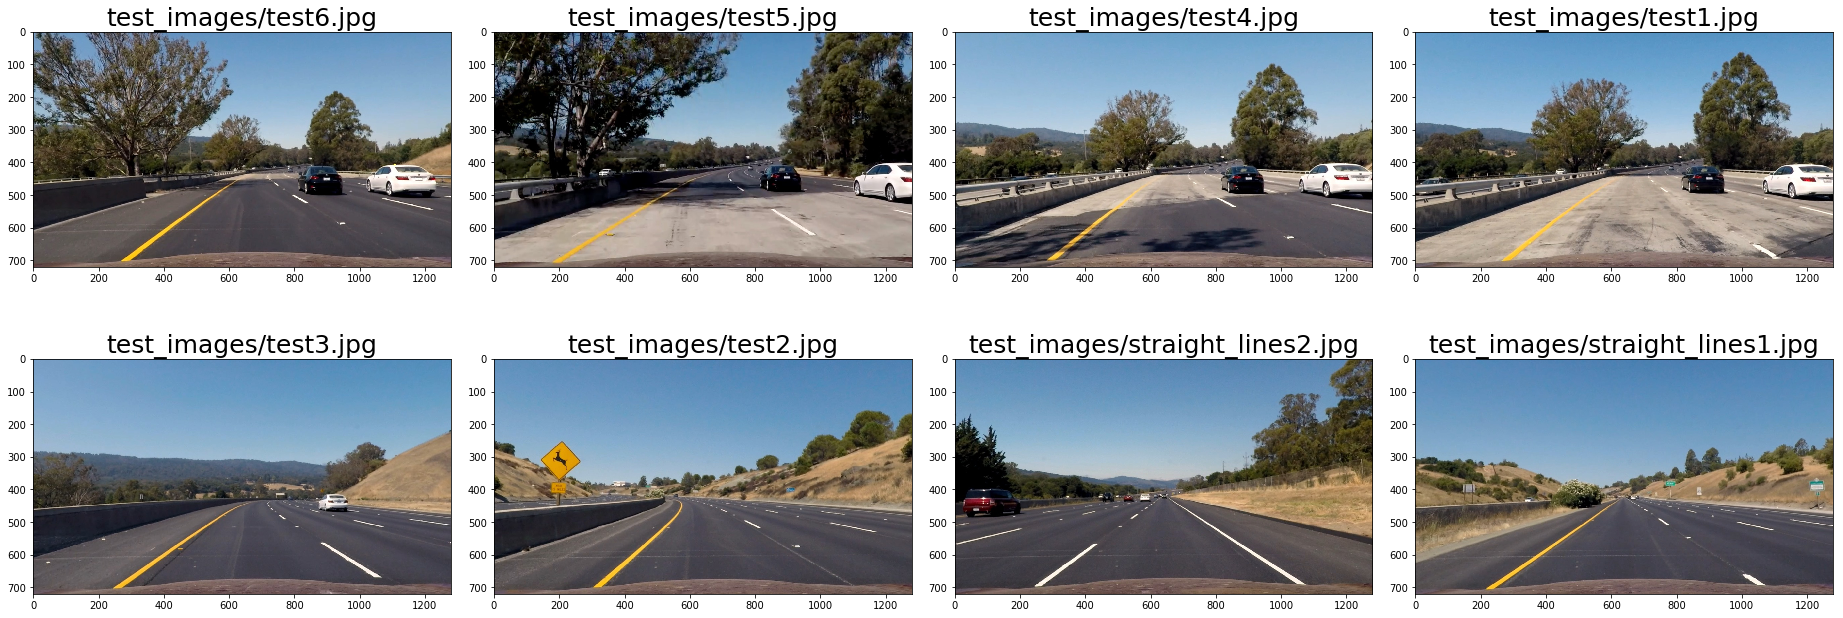

In [7]:
test_images_undistort = list(map(lambda img: (img[0], undistort(img[1])), test_images))
show_images(test_images_undistort, 4, 2, (25,6))

## Use color transforms, gradients, etc., to create a thresholded binary image

### Color Transformation (S-channel of HLS)

In [8]:
# Function that thresholds the S-channel of HLS. Use exclusive lower bound (>) and inclusive upper (<=)
def hls_s_channel(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

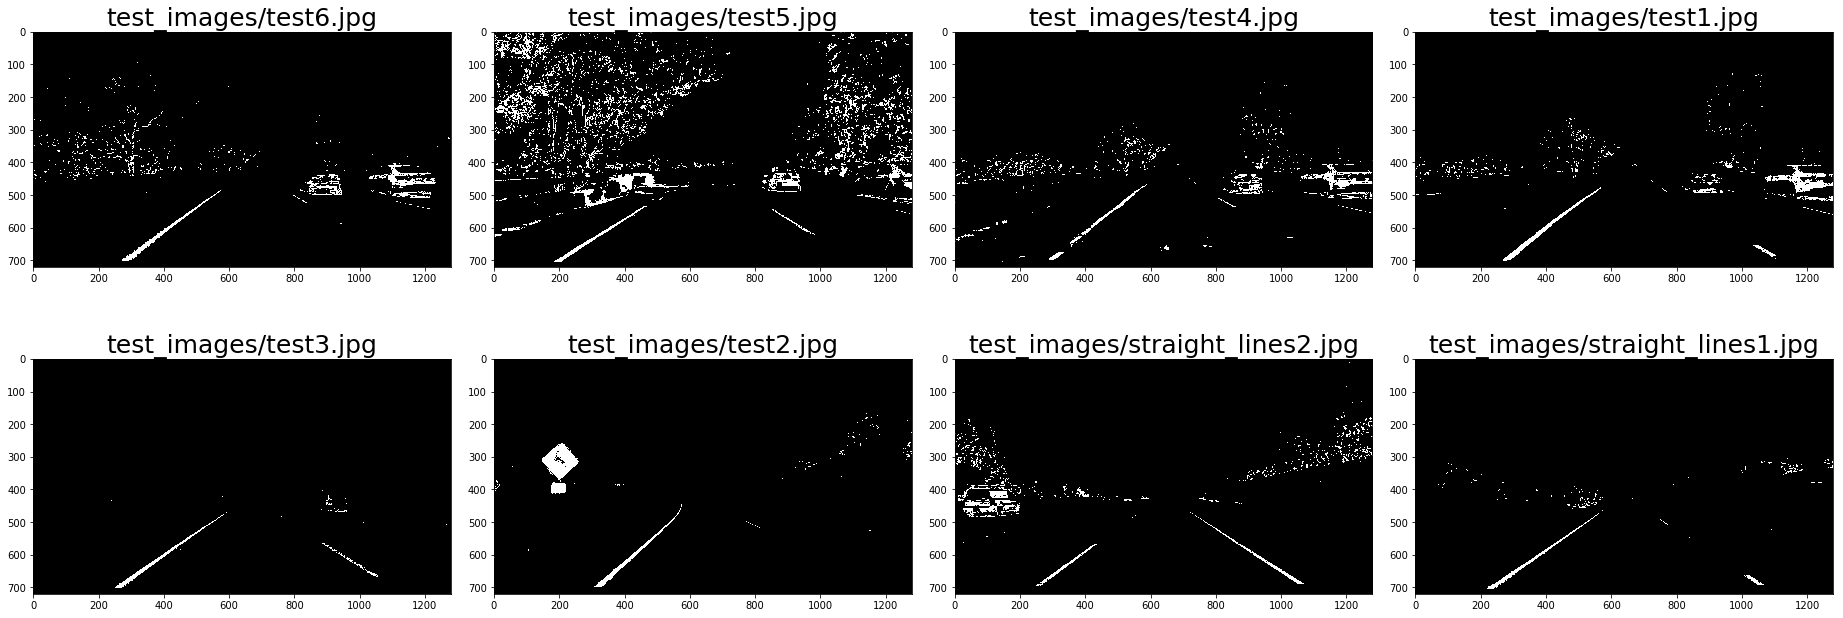

In [9]:
min_thresh = 170 # 90
max_thresh = 255
test_images_s_channel = list(map(lambda img: (img[0], hls_s_channel(img[1], (min_thresh, max_thresh))), test_images_undistort))
show_images(test_images_s_channel, 4, 2, (25,6), cmap='gray')

### Sobel Gradient Orientation

In [10]:
# Function that takes an image, gradient orientation, and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, abs_thresh=(0, 255)):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    # Gradient in x direction emphasizes edges closer to vertical. 
    # Gradient in y direction emphasizes edges closer to horizontal. 
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))   
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    
    # Return the result
    return binary_output    

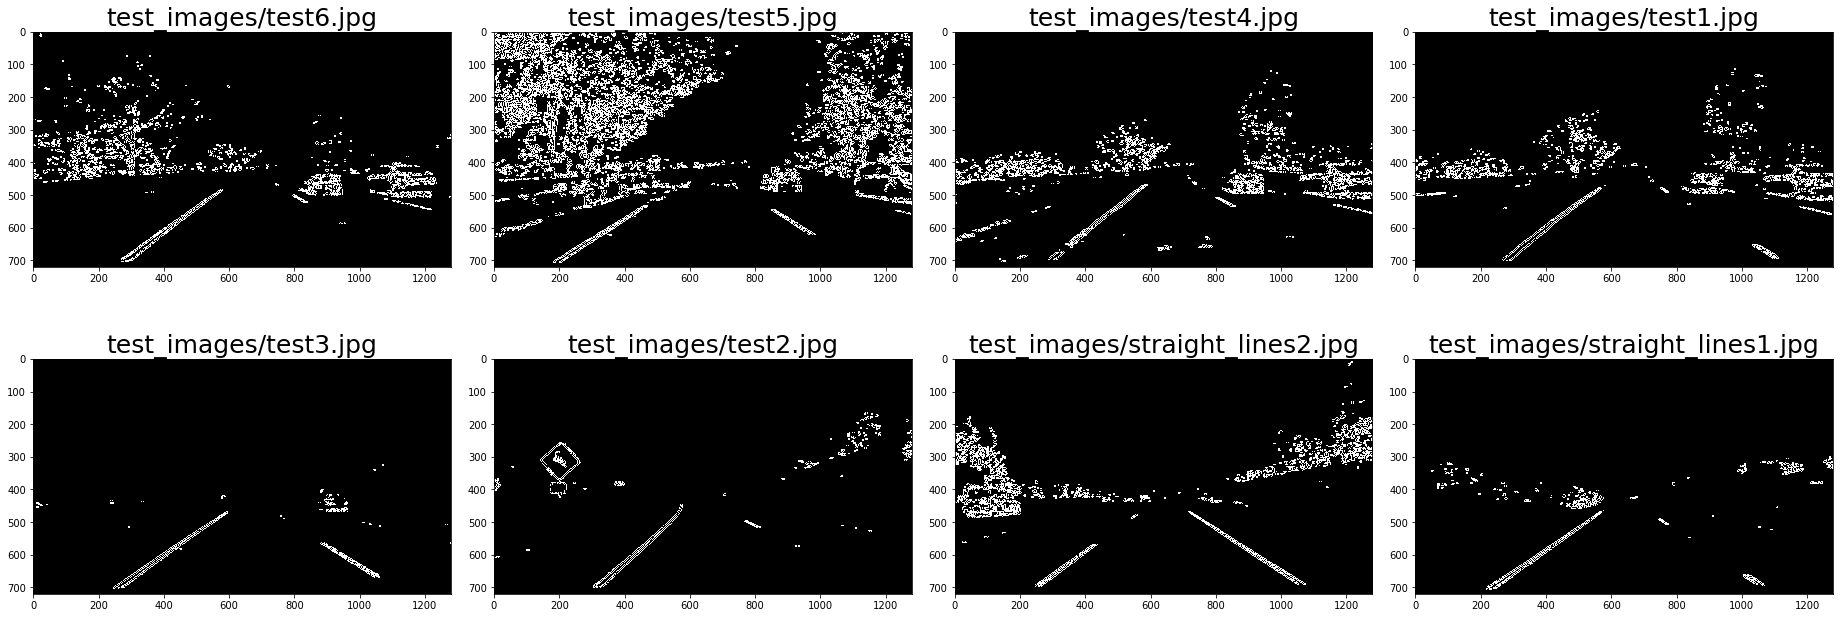

In [11]:
min_thresh = 10 
max_thresh = 120
k_size = 9
test_images_x_sobel = list(map(lambda img: (img[0], abs_sobel_thresh(img[1], 'x', k_size, (min_thresh, max_thresh))), test_images_s_channel))
show_images(test_images_x_sobel, 4, 2, (25,6), cmap='gray')

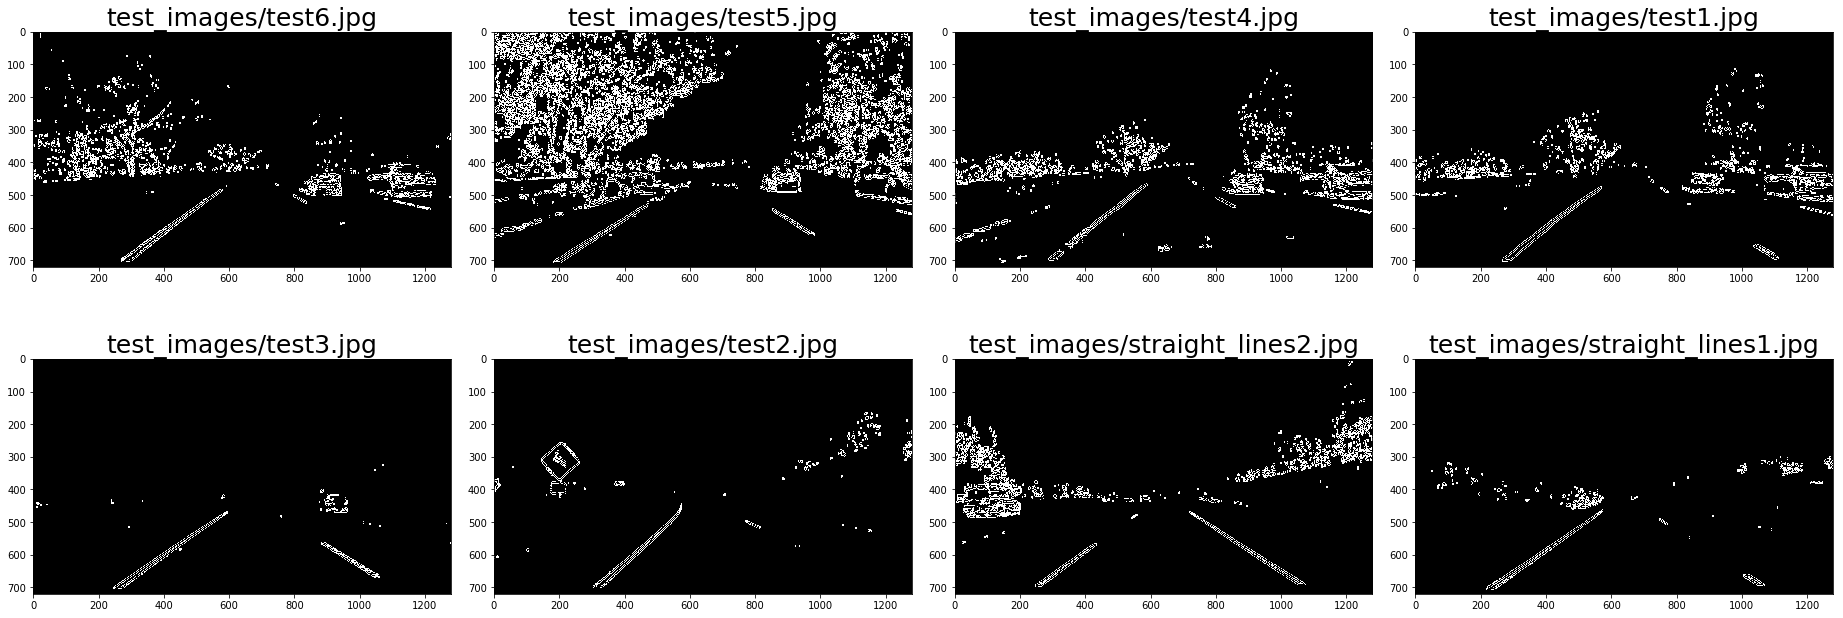

In [12]:
min_thresh = 10 
max_thresh = 120
k_size = 9
test_images_y_sobel = list(map(lambda img: (img[0], abs_sobel_thresh(img[1], 'y', k_size, (min_thresh, max_thresh))), test_images_s_channel))
show_images(test_images_y_sobel, 4, 2, (25,6), cmap='gray')

### Sobel Gradient Magnitude

In [13]:
# Function that applies Sobel x and y, then computes the magnitude of the gradient and applies a thresholds
def magnitude_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the binary image
    return binary_output
 

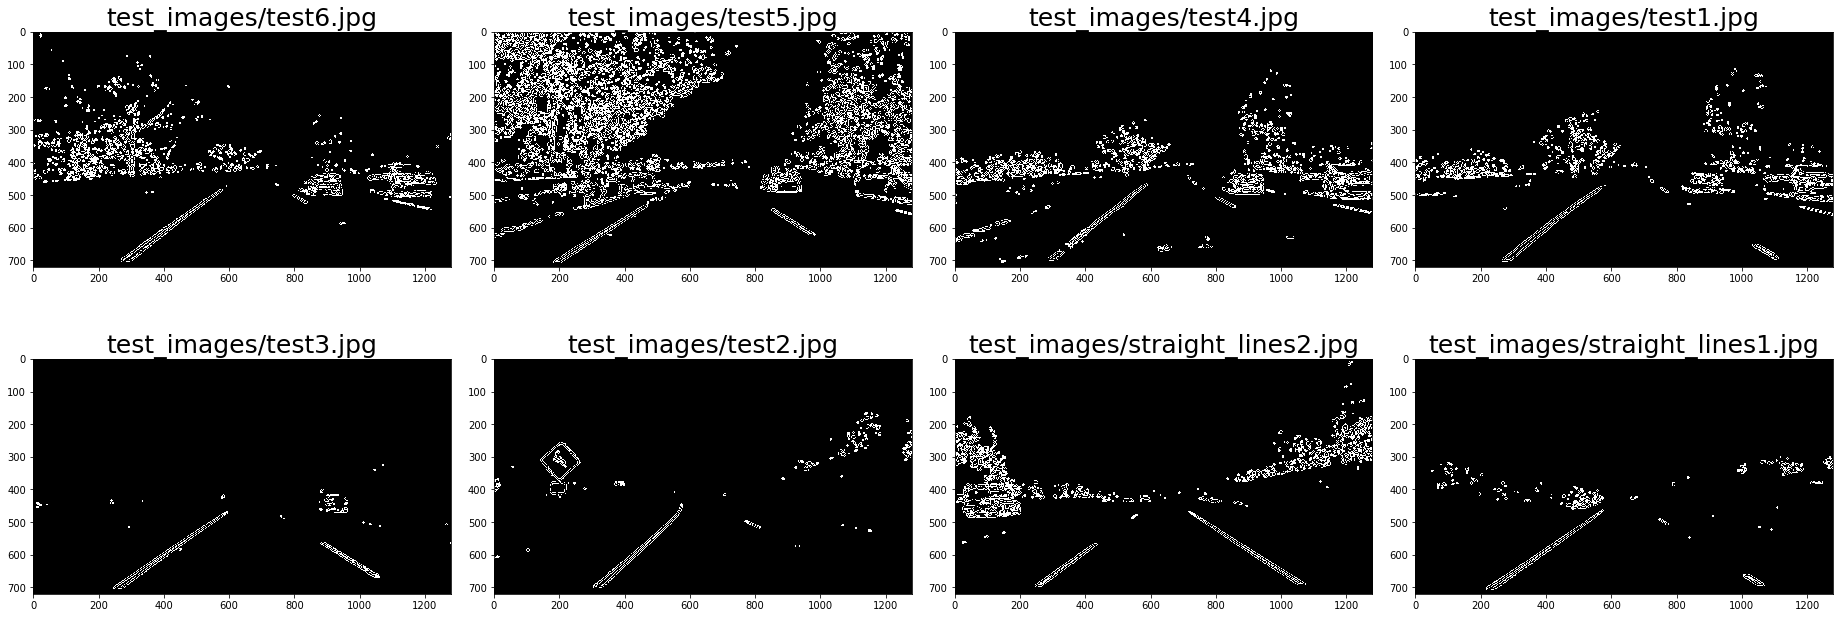

In [14]:
min_thresh = 10 
max_thresh = 120
k_size = 9
test_images_mag_sobel = list(map(lambda img: (img[0], magnitude_thresh(img[1], k_size, (min_thresh, max_thresh))), test_images_s_channel))
show_images(test_images_mag_sobel, 4, 2, (25,6), cmap='gray')

### Sobel Gradient Direction

In [15]:
# Function that applies Sobel x and y, then computes the direction of the gradient and applies a threshold.
def direction_sobel(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

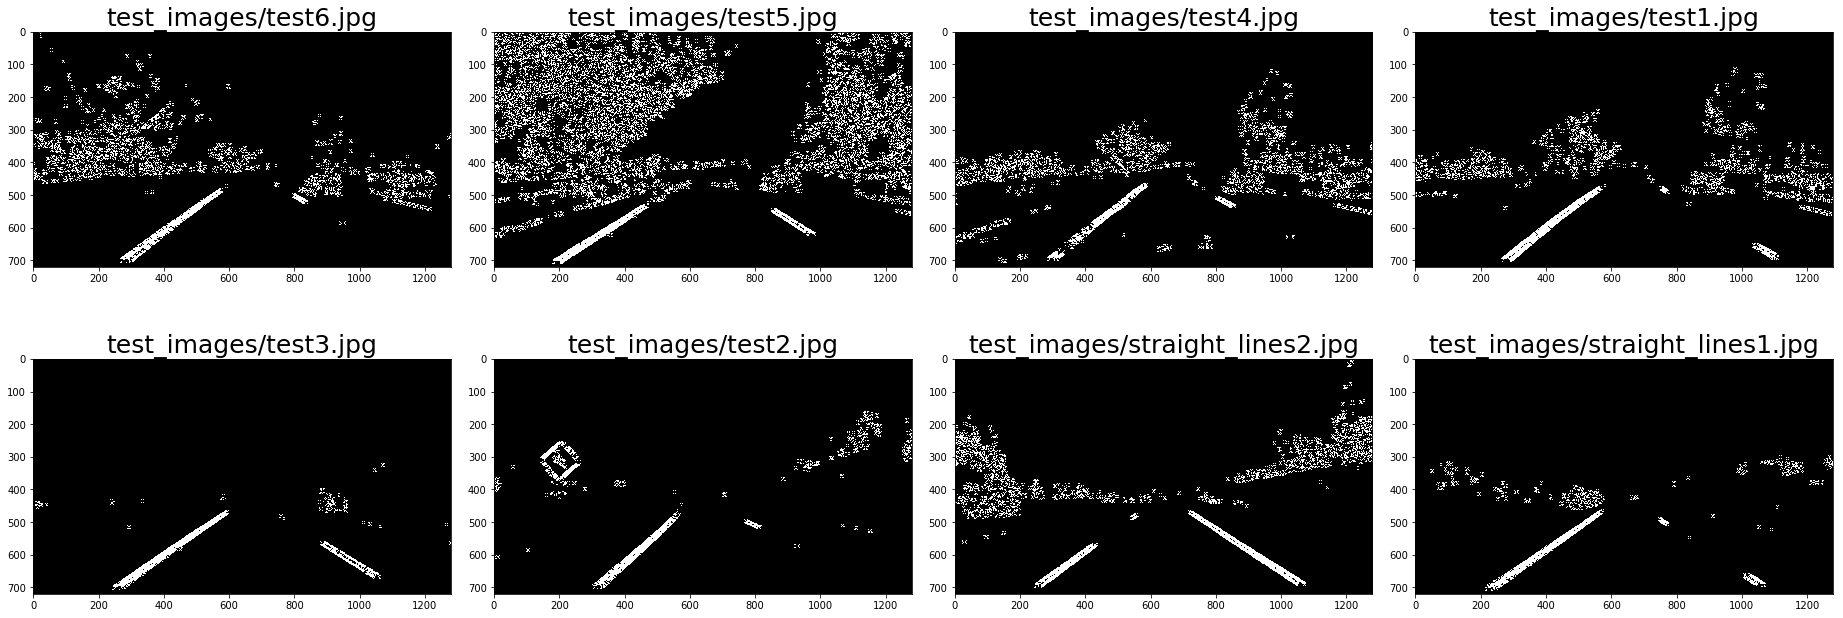

In [16]:
min_thresh = 0.7 
max_thresh = 1.3
k_size = 11
test_images_dir_sobel = list(map(lambda img: (img[0], direction_sobel(img[1], k_size, (min_thresh, max_thresh))), test_images_s_channel))
show_images(test_images_dir_sobel, 4, 2, (25,6), cmap='gray')

### Combination (sobel x + sobel y)

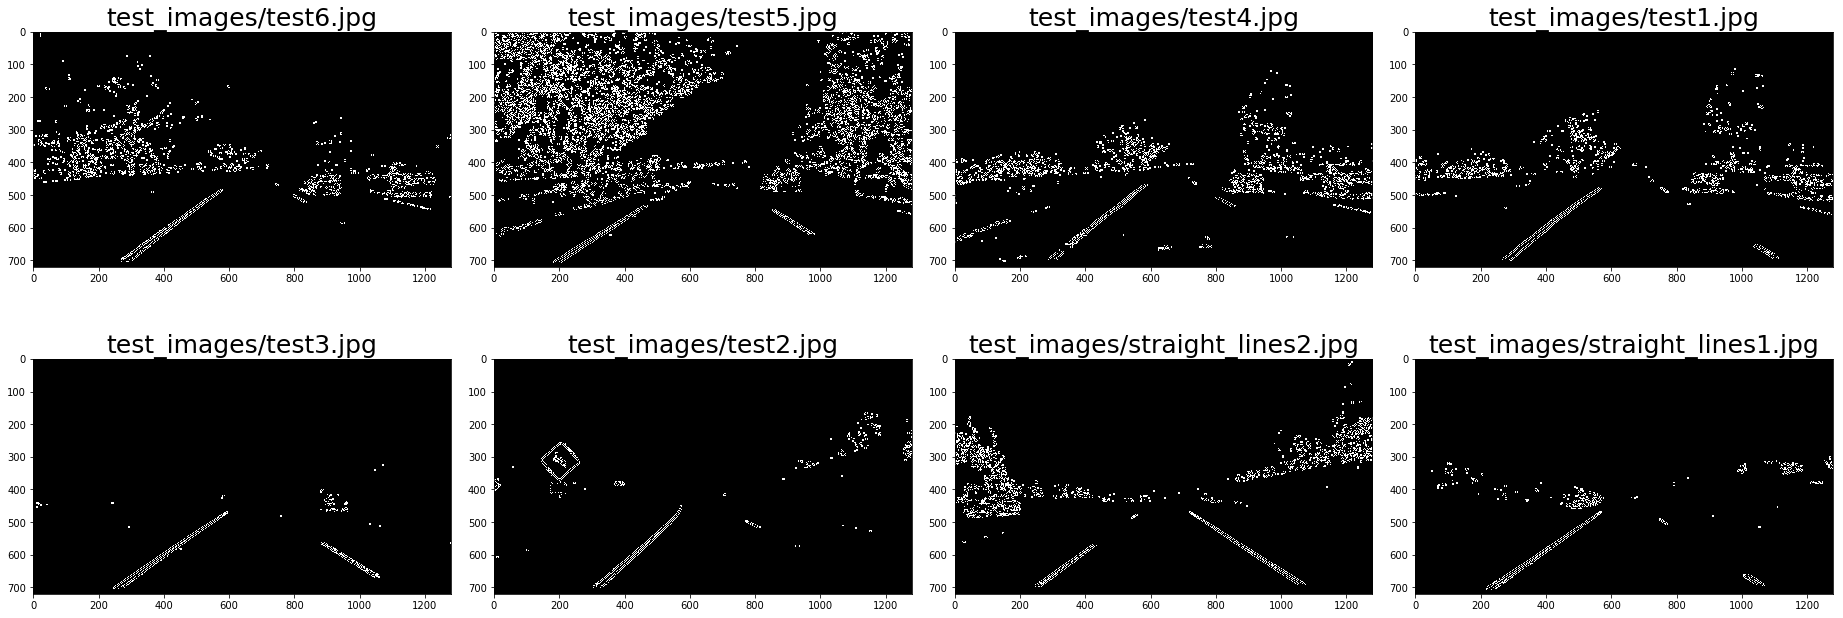

In [17]:
test_images_combined_xy = []
for i in range(len(test_images_undistort)):
    combined = []
    combined.append(test_images_undistort[i][0])
    
    combined_img = np.zeros_like(test_images_s_channel[i][1])
    combined_img[((test_images_x_sobel[i][1] == 1) & (test_images_y_sobel[i][1] == 1))] = 1
    
    combined.append(combined_img)
    test_images_combined_xy.append(combined)

# Thresholded combined
show_images(test_images_combined_xy, 4, 2, (25,6), cmap='gray')


### Combination (all)

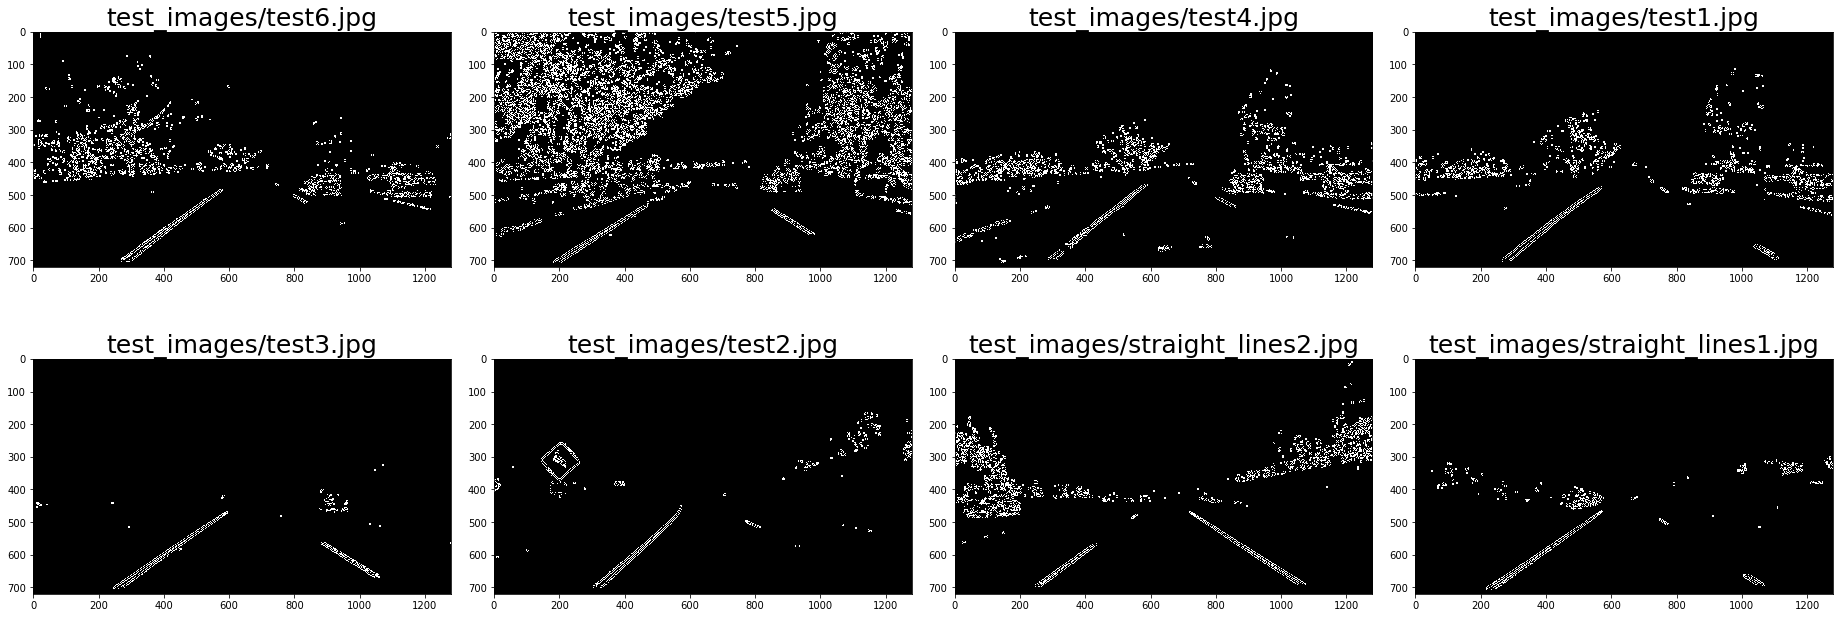

In [18]:
test_images_combined_all = []
for i in range(len(test_images_undistort)):
    combined = []
    combined.append(test_images_undistort[i][0])
    
    combined_img = np.zeros_like(test_images_s_channel[i][1])
    combined_img[((test_images_x_sobel[i][1] == 1) & (test_images_y_sobel[i][1] == 1)) 
     | ((test_images_mag_sobel[i][1] == 1) & (test_images_dir_sobel[i][1] == 1))] = 1
    
    combined.append(combined_img)
    test_images_combined_all.append(combined)

# Thresholded combined
show_images(test_images_combined_all, 4, 2, (25,6), cmap='gray')